#  Understanding the Relationship between Climate and Tree growth in Sukakpak, Alaska

![Screen Shot 2019-11-18 at 2 43 52 PM](https://user-images.githubusercontent.com/46793400/69091629-b1668400-0a18-11ea-9920-9ca70946fe61.png)"

#### Motivation
- 700 years of well correlated tree ring samples , both of living and deadwood for white spruce
- originally sampled in 1979 and updated in 2010, it hasn't been published- not straight forward for dendroclimatology 
- density of the same rings (referred here as LWBI) gives high correlations to mean JJA temp (expected for Tree line

- technical note: high index value means the tree grew alot that year, negative index means it did not

## PART 1, Import packages and Open Datasets

In [140]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime #to convert RW index to datetime
from matplotlib import pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Ring width (RW) dataset
- Pre-standardized, truncated for the calibration period (1901-2008)
- this dataset was originally standerdized using RCS -Signal Free Program by Ed COOK

In [141]:
rw=pd.read_csv('RWstd1901.csv')
a=rw['RW'].values
rw.head()

,Year,RW
0,1901,1.089
1,1902,1.075
2,1903,1.157
3,1904,0.973
4,1905,1.099


### CRU gridpoint data for Sukakpak, AK
- this data was compiled based on avg gridpoints for sites logged NOAA INTERNATIONAL TREE RING DATABASE (site code: ak106) 
- has  precip,tmax, tmin,tavg


In [142]:
#read in database data
cru=pd.read_csv('CRUsuk.csv',parse_dates = {'date_col' : ["YEAR", "MONTH"]}, keep_date_col=True )

cru['date_col'] = pd.to_datetime(cru['date_col'])
cru = cru.drop(cru.columns[[1,2,3,4]], axis=1)
df = cru.set_index('date_col')
cru.head()

,date_col,PCP,TMX,TMN,TMD
0,1901-01-01,3.0,-23.4,-33.2,-28.30
1,1901-02-01,5.0,-21.5,-33.4,-27.45
2,1901-03-01,8.0,-13.4,-25.8,-19.60
3,1901-04-01,3.0,-6.0,-17.7,-11.85
4,1901-05-01,7.0,5.6,-5.0,0.30


In [143]:
df = cru.set_index('date_col') #set index of years
df.head()


,PCP,TMX,TMN,TMD
date_col,,,,
1901-01-01,3.0,-23.4,-33.2,-28.30
1901-02-01,5.0,-21.5,-33.4,-27.45
1901-03-01,8.0,-13.4,-25.8,-19.60
1901-04-01,3.0,-6.0,-17.7,-11.85
1901-05-01,7.0,5.6,-5.0,0.30


## Convert CRU DF to xarray DS, and index by season

In [144]:
dm=df.to_xarray() #convert DF to XR DA
dm  = dm.rename({ 'date_col': 'time', })
dm = xr.decode_cf(dm)

#data variables
p=dm.PCP
tmin=dm.TMN
tmax=dm.TMX
tavg=dm.TMD

## 2A. for loop to index CRU in time, than standardize the variables to minimize outliers
- set up dictionary with keys and place to store values
- boolean: make sure we truncate CRU to same year as RW
- pulling out the seasons, per year, and take an average
- z score
- compile the series with Seasons as key

In [145]:
#For loop for pulling out seasonal data, standardizing them
x = {'p':p,'tmin': tmin,'tmax': tmax,'tavg':tavg} #assign dictionary 
y = {}
for key,val in x.items(): #assigning group and value
    #winter season
    DJF = val.where((val['time.season']=='DJF') & (val['time.year']<=2008),drop=True).groupby('time.year').mean(dim='time')
    DJFstd=((DJF-DJF.mean(dim='year')))/DJF.std(dim='year')
    #spring season 
    MAM =  val.where((val['time.season']=='MAM') & (val['time.year']<=2008),drop=True).groupby('time.year').mean(dim='time')
    MAMstd=((MAM-MAM.mean(dim='year')))/MAM.std(dim='year')
    #summer season
    JJA = val.where((val['time.season']=='JJA') & (val['time.year']<=2008),drop=True).groupby('time.year').mean(dim='time')
    JJAstd=((JJA-JJA.mean(dim='year')))/JJA.std(dim='year')
    #fall season
    SON = val.where((val['time.season']=='SON') & (val['time.year']<=2008),drop=True).groupby('time.year').mean(dim='time')
    SONstd=((SON-SON.mean(dim='year')))/SON.std(dim='year')
    seasons = pd.Series([DJFstd,MAMstd,JJAstd,SONstd], index = ['DJF', 'MAM', 'JJA', 'SON'])
    y[key] = seasons

### PART 2B. make 4 data frames , 1 for each climate variable ,with RW and seasonal means in the columns 

In [146]:
#part 3, make data frame for correlation analysis - 
#this part is prepping the data for each DF
years=rw['Year'] #setting up for index 
dfs = []

for key,value in y.items():
    d = {'RW': a, 'DJF': value['DJF'].values, 'MAM': value['MAM'].values, 'JJA': value['JJA'].values , 'SON': value['SON'].values}
    dfs.append(d)

In [147]:
#putting results into data frames with years as Index
p_DF = pd.DataFrame(data=dfs[0], index=years)
tmin_DF = pd.DataFrame(data=dfs[1], index=years)
tmax_DF = pd.DataFrame(data=dfs[2], index=years)
tavg_DF = pd.DataFrame(data=dfs[3], index=years)

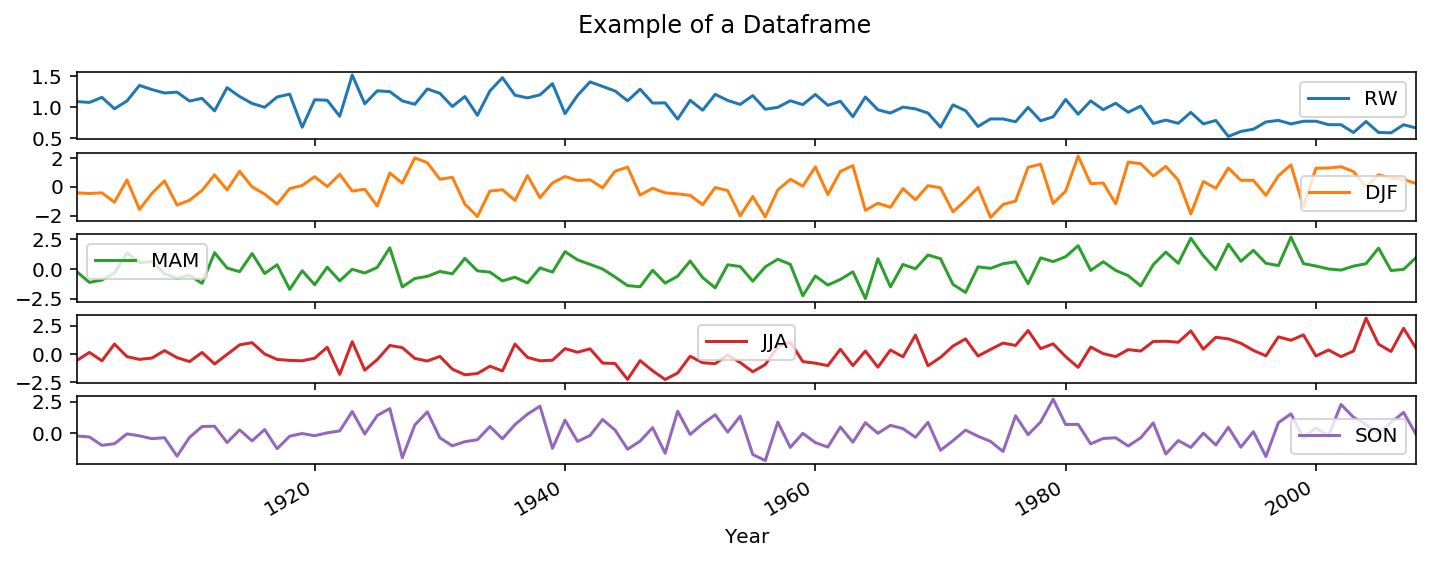

In [148]:
#what doesthis 
x=tavg_DF.plot(subplots=True,figsize=(12, 4),title="Example of a Dataframe")


## PART 3A. Correlation Matrix maps (1901-2008)
- for Ring Widths vs. Seasonality of Variables
- seaborn sns , get the corr coef for timespan

- note, there seems to be a weak negative corr for RW to season, but nothing too exciting

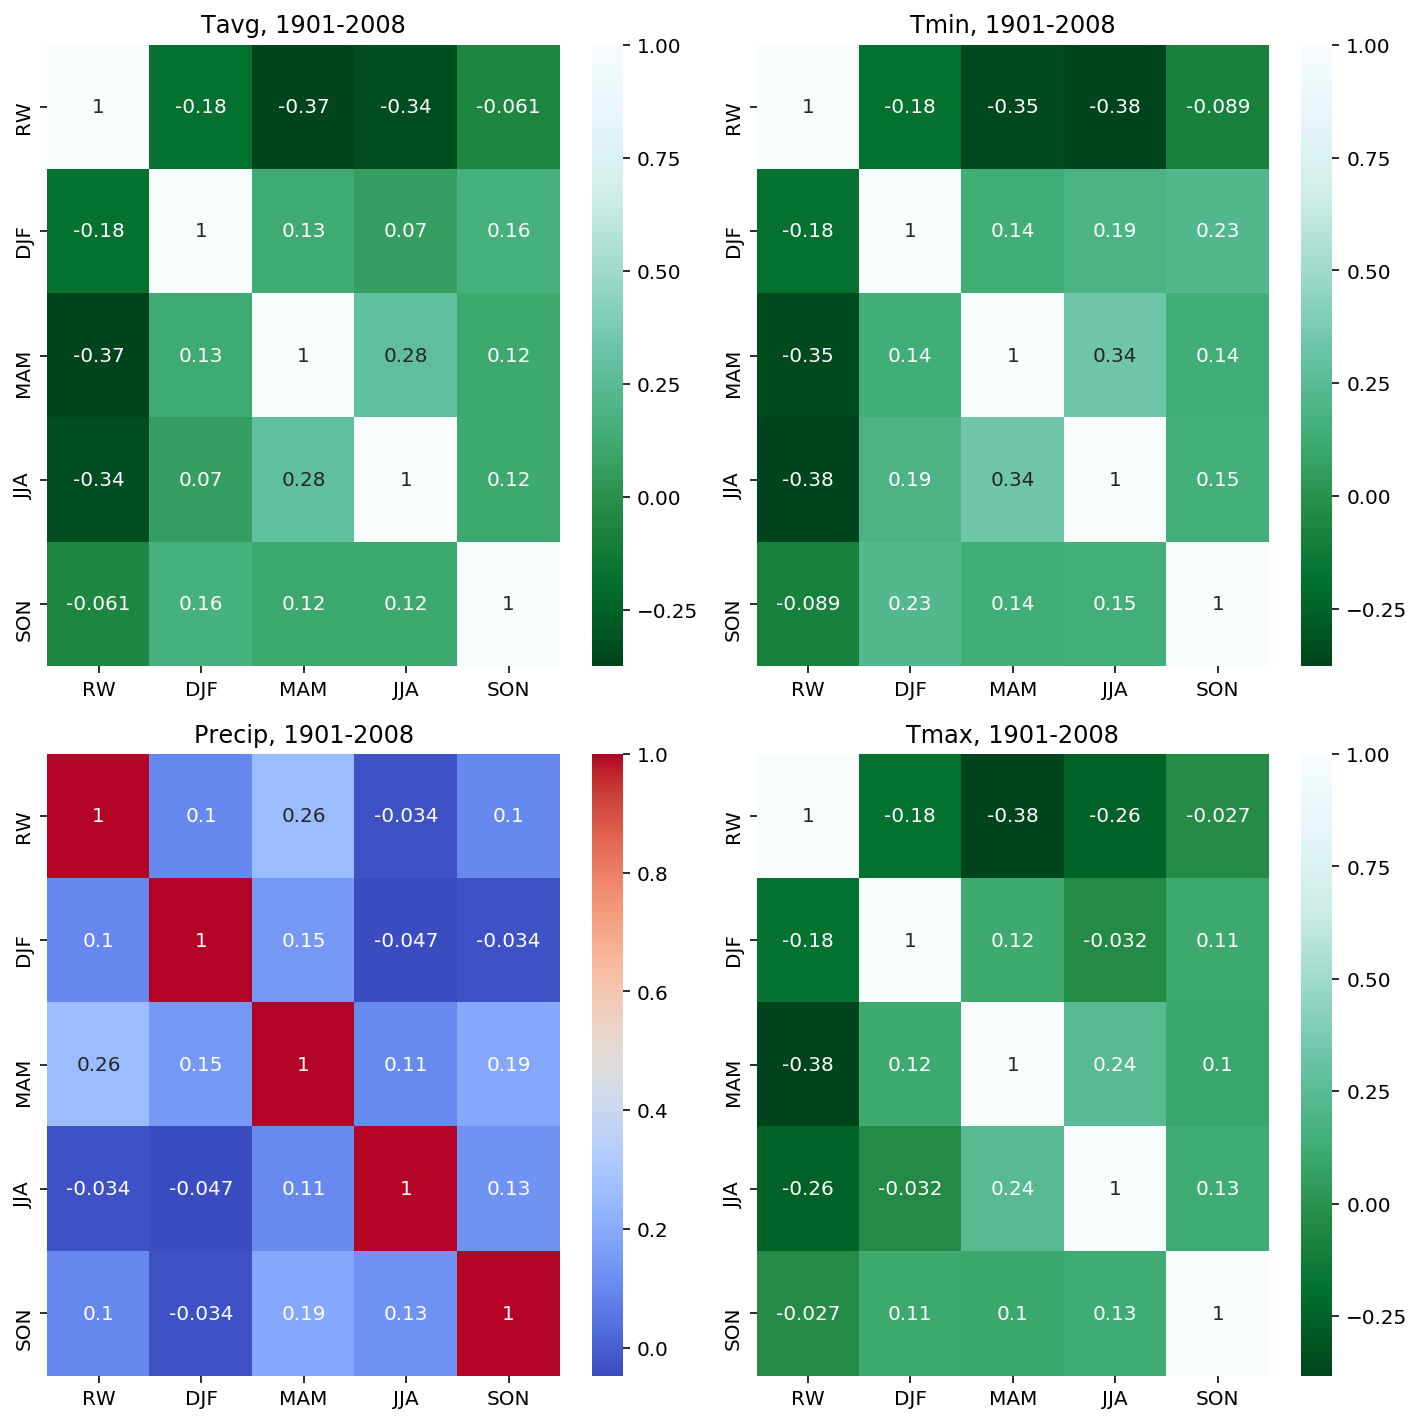

In [149]:

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10, 10) )
sns.heatmap(tavg_DF.corr(), annot=True, ax = ax[0,0],cmap="BuGn_r")
ax[0,0].set_ylim(5,0)
ax[0,0].set_title("Tavg, 1901-2008")

sns.heatmap(tmin_DF.corr(), annot=True, ax = ax[0,1], cmap="BuGn_r")
ax[0,1].set_ylim(5,0)
ax[0,1].set_title("Tmin, 1901-2008")

sns.heatmap(tmax_DF.corr(), annot=True, ax = ax[1,1], cmap="BuGn_r")
ax[1,1].set_ylim(5,0)
ax[1,1].set_title("Tmax, 1901-2008")
fig.tight_layout()

sns.heatmap(p_DF.corr(), annot=True, ax = ax[1,0], cmap="coolwarm")
ax[1,0].set_ylim(5,0)
ax[1,0].set_title("Precip, 1901-2008")
fig.tight_layout()

## 3.B Pairwise Correlations for JJA, the growing season in AK 

- Note, Only  recently has the postive relationship with temperature shifted. 

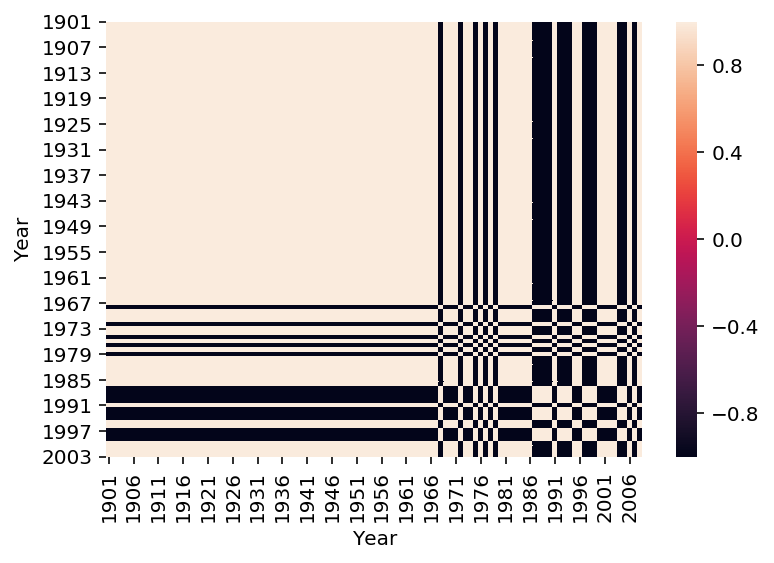

In [150]:
k=sns.heatmap(tavg_DF[['RW','JJA']].T.corr()) #transpose 

## PART 3C. Lagged Correlation tests 
- apply custom function to hold target(RW) , and lag rest 
- suggested by Andre Araujo 2018,

In [151]:
#lagging dataframe   function, suggested by Andre Araujo 2018
def df_shifted(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

In [152]:
#lagging seasonal variables by 1 year
df_new_tavg = df_shifted(tavg_DF, 'RW', lag=-1)
df_new_tavg.head()

,RW,DJF,MAM,JJA,SON
Year,,,,,
1901,1.089,-0.457919,-1.109934,0.141977,-0.313350
1902,1.075,-0.411230,-0.916321,-0.597414,-0.976559
1903,1.157,-1.059039,-0.326681,0.881369,-0.849368
1904,0.973,0.481696,1.363032,-0.227718,-0.068054
1905,1.099,-1.560945,0.544577,-0.474182,-0.222500


###   Lagged Correlations Plots: gets more complicated....
####  *these are pairwise * so 1 or -1 


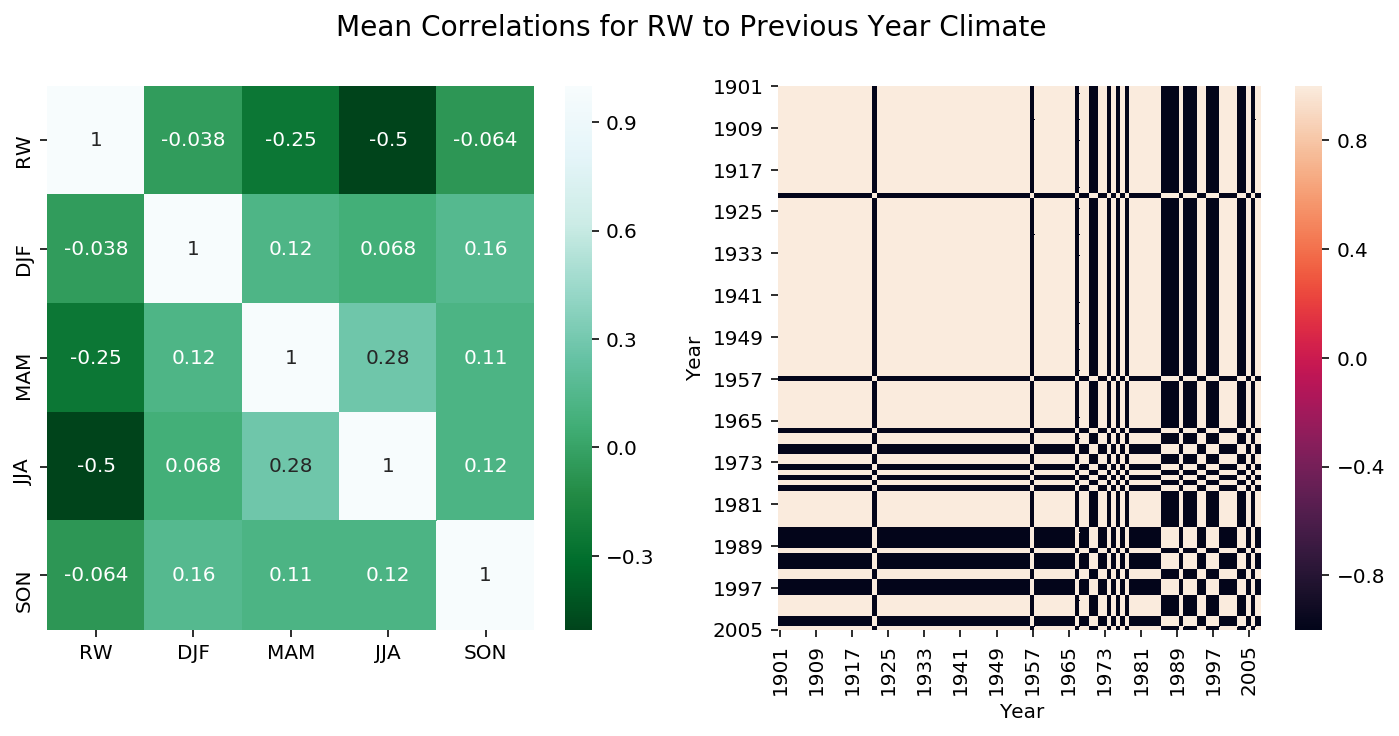

In [167]:
fig, ax = plt.subplots(ncols=2,figsize=(12,5) )
sns.heatmap(df_new_tavg.corr(), annot=True,cmap="BuGn_r",ax=ax[0], )#min and max temperature show similar neg corr for JJA
ax[0].set_ylim(5,0)
s=sns.heatmap(df_new_tavg[['RW','JJA']].T.corr(),xticklabels=8,yticklabels=8)
ax[1]

s=fig.suptitle("Mean Correlations for RW to Previous Year Climate ", fontsize=14)

## PART 3D. Plot Z-score RAW ring width, and Growing season (JJA) mean temp
- originalRW above, is standardized using RCS-SigFree program developed by ed cook
- but here, lets just normalize RW by Z-score 

In [154]:
raw=pd.read_csv('RWraw1901.csv') #open raw rw datset
rarw=raw['raw'].values
rw_z=((rarw-rarw.mean()))/rarw.std()

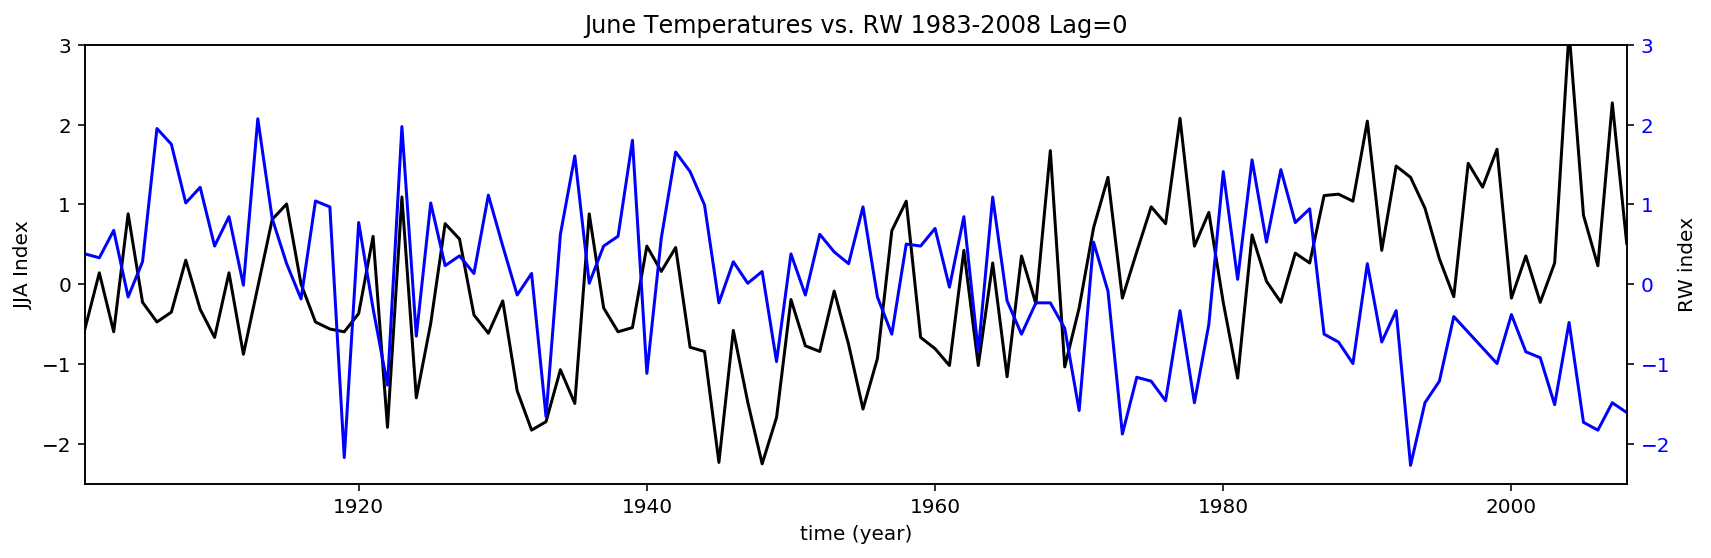

In [155]:
fig, ax1 = plt.subplots(figsize=(12, 4))
color = 'k'
year=tavg_DF.index
ax1.set_xlabel('time (year)')
ax1.set_ylabel('JJA Index')
ax1.plot(year, tavg_DF[['JJA']],color=color)
ax1.tick_params(axis='y',labelcolor=color)
ax1.set_ylim(-2.5,3)
ax1.set_xlim()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'b'
ax2.set_ylabel('RW index')  # we already handled the x-label with ax1
ax2.plot(year, rw_z, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-2.5,3)
ax2.set_xlim(1901,2008)
ax2.set_title('June Temperatures vs. RW 1983-2008 Lag=0')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



#### ABOVE: there are periods of aggreement between RW and JJA temp until recently (~post 1986)

## PART 4A. Access CRU temp data directly 
- for larger spatial grid
- perhaps the standard seasonality isnt what is driving growth rings, need to look at individual months

In [156]:
## spatio temporal correlations with larger grid
#! wget https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.03/cruts.1905011326.v4.03/tmp/cru_ts4.03.1901.2018.tmp.dat.nc.gz
#! gunzip cru_ts4.03.1901.2018.tmp.dat.nc.gz


--2019-12-06 04:18:35--  https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.03/cruts.1905011326.v4.03/tmp/cru_ts4.03.1901.2018.tmp.dat.nc.gz
Resolving crudata.uea.ac.uk (crudata.uea.ac.uk)... 139.222.133.100
Connecting to crudata.uea.ac.uk (crudata.uea.ac.uk)|139.222.133.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166487213 (159M) [application/x-gzip]
Saving to: ‘cru_ts4.03.1901.2018.tmp.dat.nc.gz’

cru_ts4.03.1901.201 100%[===================>] 158.77M  5.08MB/s    in 33s     

2019-12-06 04:19:09 (4.78 MB/s) - ‘cru_ts4.03.1901.2018.tmp.dat.nc.gz’ saved [166487213/166487213]

gzip: cru_ts4.03.1901.2018.tmp.dat.nc already exists; do you wish to overwrite (y or n)? ^C


In [157]:
# opening up cru data
dst = xr.open_dataset('cru_ts4.03.1901.2018.tmp.dat.nc') #monthly climate data 
ds = dst.sel(time=slice('1901', '2008'),lon=slice(-170.75,-140.75),lat=slice(50.75,72)) 

tmpu=ds.tmp



#### Look at summer Temperature over Calibration Period

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


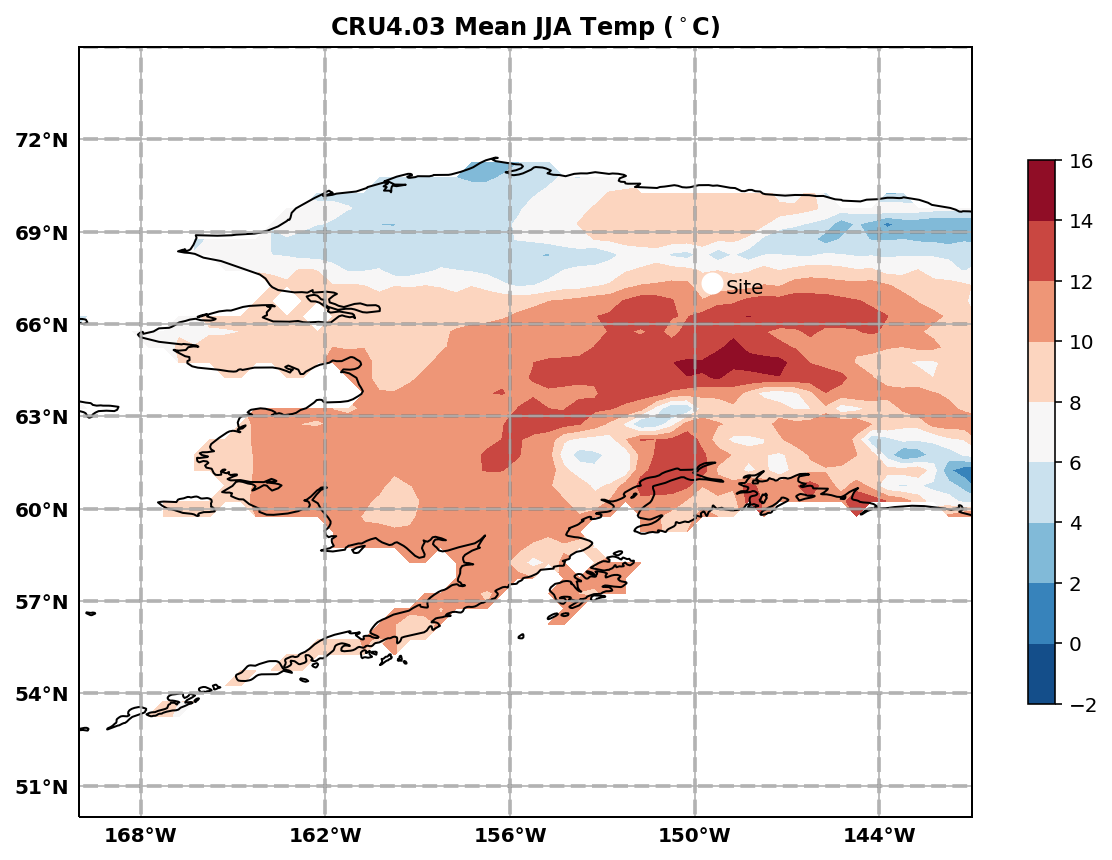

In [158]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


tsub=d_SUB.tmp # assign datavariable 
tmpJ = tsub.where((tsub['time.season']=='JJA')&((tsub['time.year']<=2008)&(tsub['time.year']>=1901)),drop=True).groupby('time.year').mean(dim='time')


tmpJJA_sub=tmpJ.mean(dim=['year'])

extent=[-170,-141,50,75]
fig = plt.figure(figsize=(10,10))
ax = fig.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)
Jmap=ax.contourf(tmpJJA_sub.lon.values,tmpJJA_sub.lat.values,tmpJJA_sub,cmap='RdBu_r',transform=ccrs.PlateCarree() )
a=plt.title('CRU4.03 Mean JJA Temp ($^\circ$C)', weight='bold')

fig.colorbar(Jmap,shrink=.5);
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
gl.ylabel_style={'color': 'black', 'weight': 'bold'}
# mark a known place to help us geo-locate ourselves
ax.plot(-149.447, 67.335, 'wo', markersize=10, transform=ccrs.Geodetic())
ax.text(-149, 67, 'Site', transform=ccrs.Geodetic())

ax.gridlines()
ax.coastlines(resolution='50m')

# Part 5. ** ANALYSIS TURNING POINT ***
   - originaly i had done several lags but looking at other months, and time periods (JUNE only for example) but this is now deleted
   
   - it occured to me , this particular Ring width timeseries (as shown in the beginning) was pre-cleaned and standardized in the same way the density chronology was for comparison
   - latewood  blue light intensity  (LWBI) is an indirect measure of the density in tree rings. It is a relatively new parameter in the field 
   - i realize these parameters may not be measuring the same growth variable, in other words, they need to be treated differently
   - Although the original PIs that sampled this site still had difficulty with the standardizing RW dataset alone, i figured i would play around with different methods myself and re-check correlations

## 5A. Load RW data standardized with negative exponential curve
- Modified Negative Exponential regression is the baseline method to remove non climatic trends such as the "Biological age Trend" ( ringwidth is wider towards the center of the tree due to fast growth at a young age)
- other standardization methods usually apply on top of this negative exponential , but for simplicity, I will just display the data for Neg Exp only

In [223]:
#load Rw and parse date col

#reload and parse dates for OG chronology standardizedby SF
rwsf=pd.read_csv('RWstd1901.csv',parse_dates = {'date_col' : ["Year"]},keep_date_col=True)
rwsf['date_col'] = pd.to_datetime(rw['date_col'])

#neg exp
rwn=pd.read_csv('RWneg.csv',parse_dates = {'date_col' : ["year"]},keep_date_col=True)
rwn['date_col'] = pd.to_datetime(rwn['date_col'])
rwsf.head()

,date_col,Year,RW
0,1901-01-01,1901,1.089
1,1902-01-01,1902,1.075
2,1903-01-01,1903,1.157
3,1904-01-01,1904,0.973
4,1905-01-01,1905,1.099


In [224]:
#SF 
df1 = rwsf.drop(rwsf.columns[[1]], axis=1) # drop old year column
df1 = df1.set_index('date_col')
dfn=df1.rename(index={'time': 'date_col'})
dfn.head()

,RW
date_col,
1901-01-01,1.089
1902-01-01,1.075
1903-01-01,1.157
1904-01-01,0.973
1905-01-01,1.099


In [225]:
#neg exp
rwn = rwn.drop(rwn.columns[[1]], axis=1) # drop old year column
rwn = rwn.set_index('date_col')
rwn.head()



,std
date_col,
1901-01-01,0.970
1902-01-01,0.971
1903-01-01,1.029
1904-01-01,0.884
1905-01-01,0.945


In [226]:
dm=df1.to_xarray() #convert DF to XR DA
dm  = dm.rename({ 'date_col': 'time', }) #rename date column
dm

<xarray.Dataset>
Dimensions:  (time: 108)
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2008-01-01
Data variables:
    RW       (time) float64 1.089 1.075 1.157 0.973 ... 0.592 0.586 0.716 0.664

In [227]:

#negexp
dmn=rwn.to_xarray() #convert DF to XR DA
dmn  = dmn.rename({ 'date_col': 'time', }) #rename date column
dmn = xr.decode_cf(dmn)
#groupby
gbRW=dm.groupby('time.year').mean(dim='time')#SF



In [228]:
gbRWn = dmn.groupby('time.year').mean(dim='time') #negexp

In [229]:
#neg exp
dm1n=gbRWn.sel(year=slice('1901','1985')) #first period
dmn=gbRWn.sel(year=slice('1986','2008'))  #second period 

#sf
dm1=gbRW.sel(year=slice('1901','1985')) #first period
dm=gbRW.sel(year=slice('1986','2008'))  #second period 
dmn

<xarray.Dataset>
Dimensions:  (year: 23)
Coordinates:
  * year     (year) int64 1986 1987 1988 1989 1990 ... 2004 2005 2006 2007 2008
Data variables:
    std      (year) float64 1.139 0.884 0.94 0.899 ... 0.887 0.931 1.05 0.966

### 5B. 1901-1985 JJA indexing and correlations

In [230]:
#indexing TEMP by season 
tmpJu = tmpu.where((tmpu['time.season']=='JJA')&((tmpu['time.year']<=1985)&(tmpu['time.year']>=1901)),drop=True).groupby('time.year').mean(dim='time')
#tmpJu=tmpJu.shift(year=-1, fill_value=0) # i could lag via x-array
tmpJ_std1=((tmpJu-tmpJu.mean(dim='year')))/tmpJu.std(dim='year') #standardizing by time first


#NEG EXP
#empty data array 
corrJJA01 = xr.DataArray(np.ones((tmpJ_std1.shape[1],tmpJ_std1.shape[2])),dims=['lat', 'lon'],
                  coords={'lat': tmpJ_std1.lat.values,
                         'lon': tmpJ_std1.lon.values},)
#Loop & calculate correlations for each grid pt
for row in np.arange(0,tmpJ_std1.shape[1]):  
    for col in np.arange(0,tmpJ_std1.shape[2]):  
        corrJJA01.values[row,col] = np.corrcoef((dm1n['std'].values,tmpJ_std1.values[:,row,col]))[0,1]

#SF
#empty data array 
corrsfJJA01 = xr.DataArray(np.ones((tmpJ_std1.shape[1],tmpJ_std1.shape[2])),dims=['lat', 'lon'],
                  coords={'lat': tmpJ_std1.lat.values,
                         'lon': tmpJ_std1.lon.values},)
#Loop & calculate correlations for each grid pt
for row in np.arange(0,tmpJ_std1.shape[1]):  
    for col in np.arange(0,tmpJ_std1.shape[2]):  
        corrsfJJA01.values[row,col] = np.corrcoef((dm1['RW'].values,tmpJ_std1.values[:,row,col]))[0,1]




/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


### 5C. 1986-2008 JJA Indexing and correlations

In [231]:

tmpJu = tmpu.where((tmpu['time.month']==6)&((tmpu['time.year']<=2008)&(tmpu['time.year']>=1986)),drop=True).groupby('time.year').mean(dim='time')
#tmpJu=tmpJu.shift(year=-1, fill_value=0)
tmpJ_std=((tmpJu-tmpJu.mean(dim='year')))/tmpJu.std(dim='year') #standardizing by time first
tmpJJAgrid=tmpJ_std.mean(dim=['lat','lon'])

#empty data array 
corrJJA86 = xr.DataArray(np.ones((tmpJ_std.shape[1],tmpJ_std.shape[2])),dims=['lat', 'lon'],
                  coords={'lat': tmpJ_std.lat.values,
                         'lon': tmpJ_std.lon.values},)
#Loop & calculate correlations for each grid pt
for row in np.arange(0,tmpJ_std.shape[1]):  
    for col in np.arange(0,tmpJ_std.shape[2]):  
        corrJJA86.values[row,col] = np.corrcoef((dmn['std'].values,tmpJ_std.values[:,row,col]))[0,1]

corrsfJJA86 = xr.DataArray(np.ones((tmpJ_std1.shape[1],tmpJ_std1.shape[2])),dims=['lat', 'lon'],
                  coords={'lat': tmpJ_std1.lat.values,
                         'lon': tmpJ_std1.lon.values},)
#Loop & calculate correlations for each grid pt
for row in np.arange(0,tmpJ_std1.shape[1]):  
    for col in np.arange(0,tmpJ_std1.shape[2]):  
        corrsfJJA86.values[row,col] = np.corrcoef((dm['RW'].values,tmpJ_std.values[:,row,col]))[0,1]




/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


## 5D. Correlation Maps
- note to self: need to do for loop  for these maps

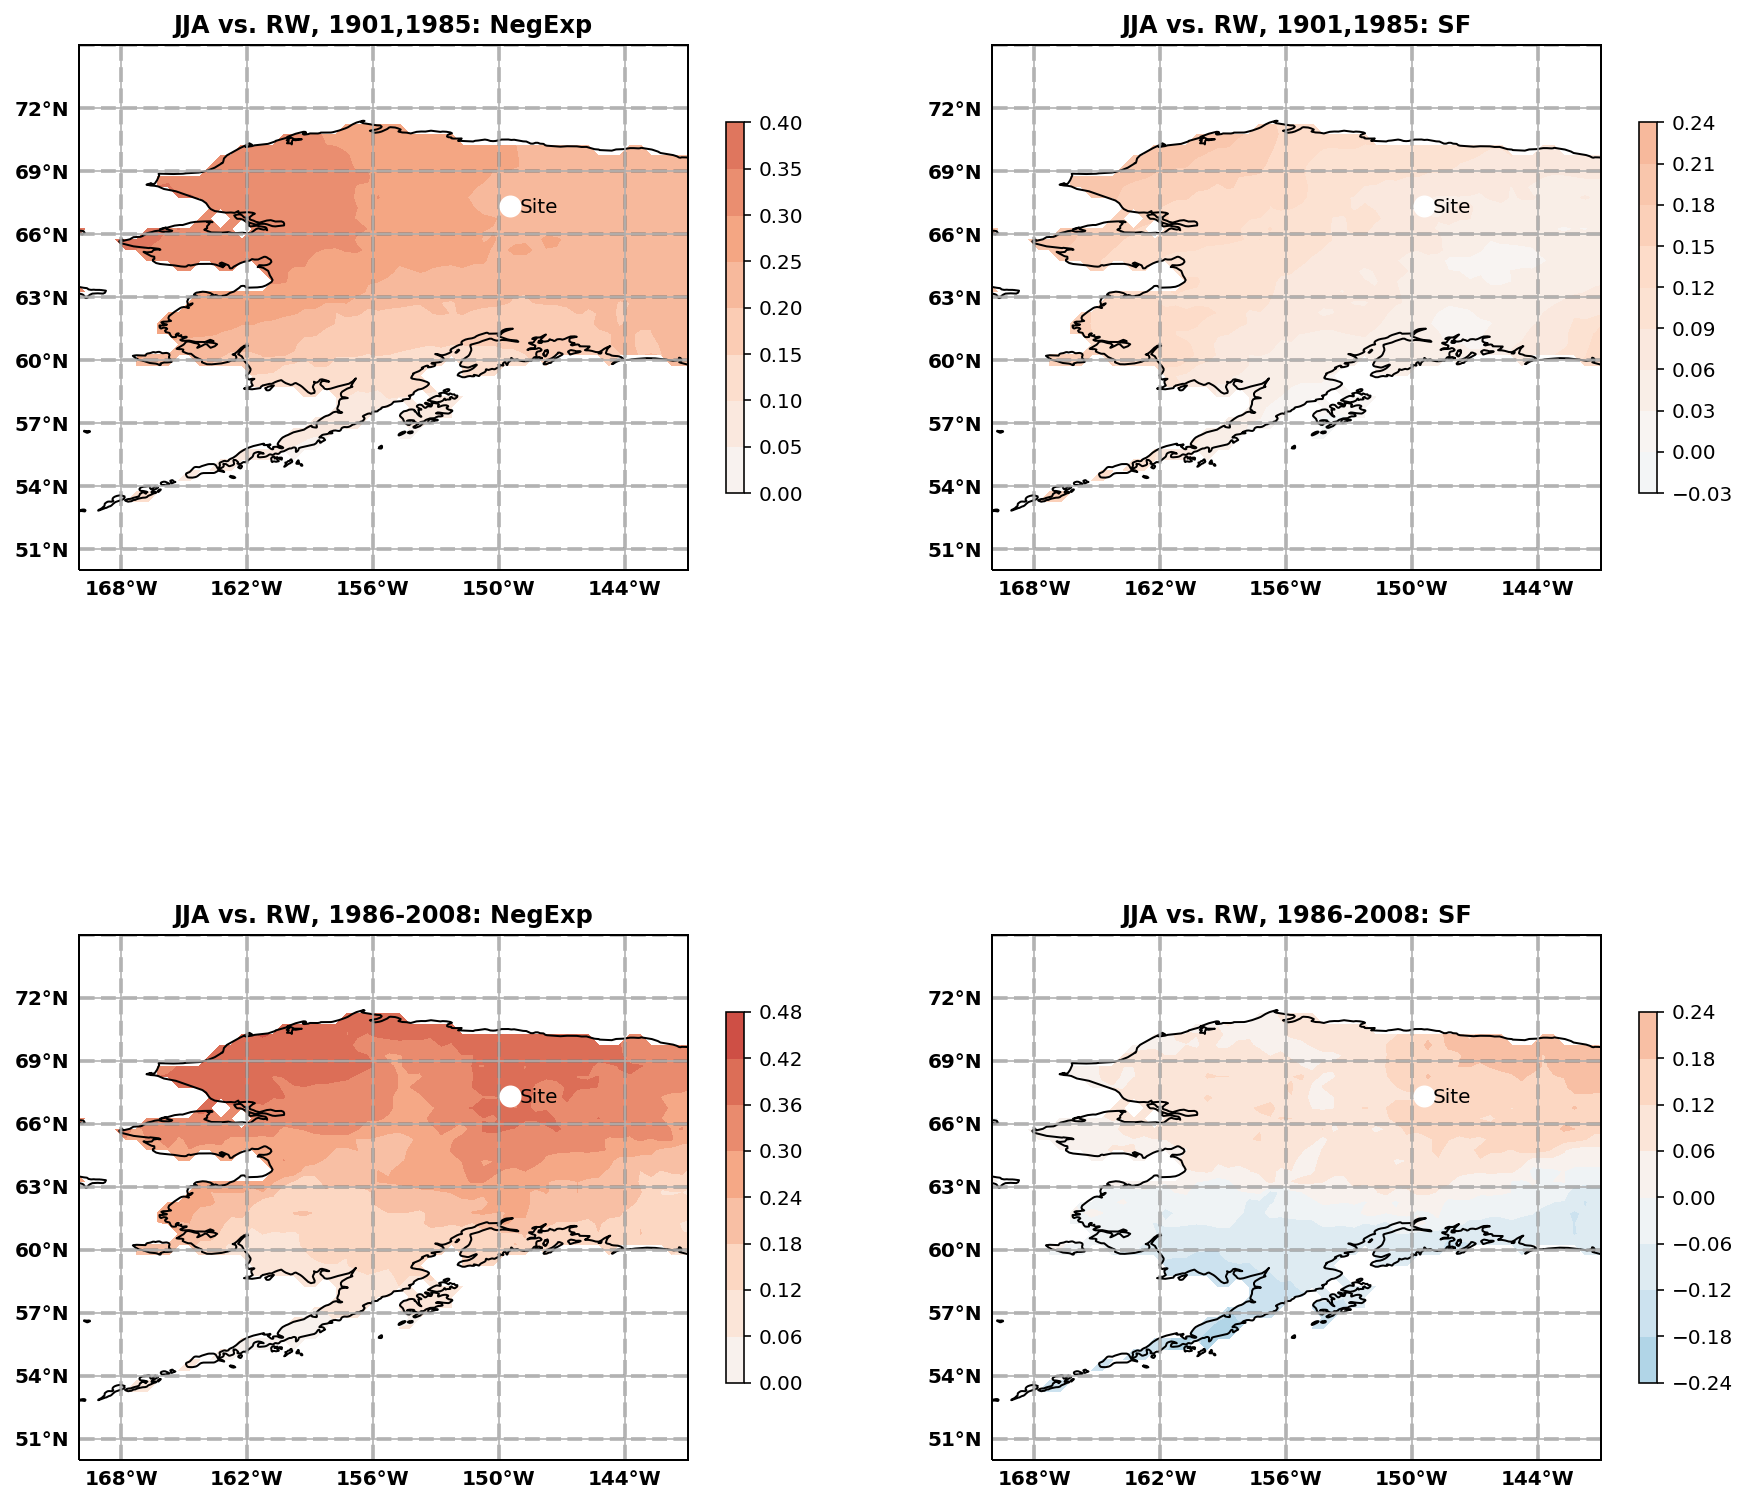

In [232]:
#1901-1986 correlations
extent=[-170,-141,50,75]
fig = plt.figure(figsize=(15,15))  #Initialize figure size
#Initialize 2 subplots, assign to variable names ax
ax = fig.subplots(ncols=2,nrows=2,subplot_kw={'projection': ccrs.PlateCarree()}) 

##1901 map
JJA1901map=ax[0,0].contourf(corrJJA01.lon.values,corrJJA01.lat.values,corrJJA01,vmin=-.7,vmax=.7,cmap='RdBu_r',transform=ccrs.PlateCarree() );
gl = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax[0,0].set_title('JJA vs. RW, 1901,1985: NegExp', weight='bold')
cb1901=fig.colorbar(JJA1901map, ax=ax[0,0],shrink=.5);
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
gl.ylabel_style={'color': 'black', 'weight': 'bold'}
# mark a known place to help us geo-locate ourselves
ax[0,0].plot(-149.447, 67.335, 'wo', markersize=10, transform=ccrs.Geodetic())
ax[0,0].text(-149, 67, 'Site', transform=ccrs.Geodetic())
ax[0,0].gridlines()
ax[0,0].coastlines(resolution='50m')
ax[0,0].set_extent(extent)

### 1986 Map

J1986map=ax[1,0].contourf(corrJJA86.lon.values,corrJJA86.lat.values,corrJJA86,vmin=-.7,vmax=.7,cmap='RdBu_r',transform=ccrs.PlateCarree() );
gl = ax[1,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax[1,0].set_title('JJA vs. RW, 1986-2008: NegExp', weight='bold')
cb1986=fig.colorbar(J1986map, ax=ax[1,0],shrink=.5);
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
gl.ylabel_style={'color': 'black', 'weight': 'bold'}
# mark a known place to help us geo-locate ourselves
ax[1,0].plot(-149.447, 67.335, 'wo', markersize=10, transform=ccrs.Geodetic())
ax[1,0].text(-149, 67, 'Site', transform=ccrs.Geodetic())
ax[1,0].gridlines()
ax[1,0].coastlines(resolution='50m')
ax[1,0].set_extent(extent)


##1901 map
JJA1901sfmap=ax[0,1].contourf(corrsfJJA01.lon.values,corrsfJJA01.lat.values,corrsfJJA01,vmin=-.7,vmax=.7,cmap='RdBu_r',transform=ccrs.PlateCarree() );
gl = ax[0,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax[0,1].set_title('JJA vs. RW, 1901,1985: SF', weight='bold')
cb1901=fig.colorbar(JJA1901sfmap, ax=ax[0,1],shrink=.5);
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
gl.ylabel_style={'color': 'black', 'weight': 'bold'}
# mark a known place to help us geo-locate ourselves
ax[0,1].plot(-149.447, 67.335, 'wo', markersize=10, transform=ccrs.Geodetic())
ax[0,1].text(-149, 67, 'Site', transform=ccrs.Geodetic())
ax[0,1].gridlines()
ax[0,1].coastlines(resolution='50m')
ax[0,1].set_extent(extent)

### 1986 Map

J1986sfmap=ax[1,1].contourf(corrsfJJA86.lon.values,corrsfJJA86.lat.values,corrsfJJA86,vmin=-.7,vmax=.7,cmap='RdBu_r',transform=ccrs.PlateCarree() );
gl = ax[1,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax[1,1].set_title('JJA vs. RW, 1986-2008: SF', weight='bold')
cb1986=fig.colorbar(J1986sfmap, ax=ax[1,1],shrink=.5);
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
gl.ylabel_style={'color': 'black', 'weight': 'bold'}
# mark a known place to help us geo-locate ourselves
ax[1,1].plot(-149.447, 67.335, 'wo', markersize=10, transform=ccrs.Geodetic())
ax[1,1].text(-149, 67, 'Site', transform=ccrs.Geodetic())
ax[1,1].gridlines()
ax[1,1].coastlines(resolution='50m')
ax[1,1].set_extent(extent)

#### Above: 
- Left, Neg exp chronology (nice correlations) vs. signal free chronology (misleading)

## Caveats for using Negative Exponential ? 
- Losing low frequency information
- standardizing tree ring data is majorly subjective, and differs in site, species, and-as I have learned- parameter


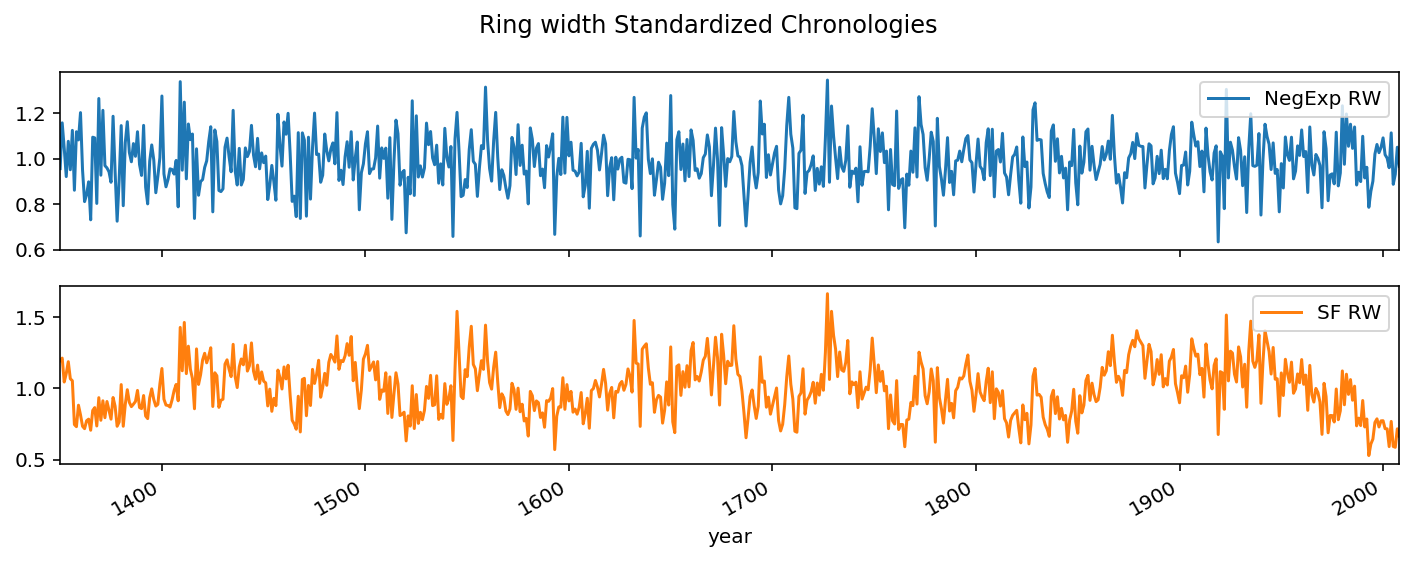

In [233]:
rwboth=pd.read_csv('RWboth.csv')
rwboth = rwboth.set_index('year')

x=rwboth.plot(subplots=True, figsize=(12, 4),title="Ring width Standardized Chronologies")


## You've been referencing it the whole time, What does the LWBI (density chronology) look like?

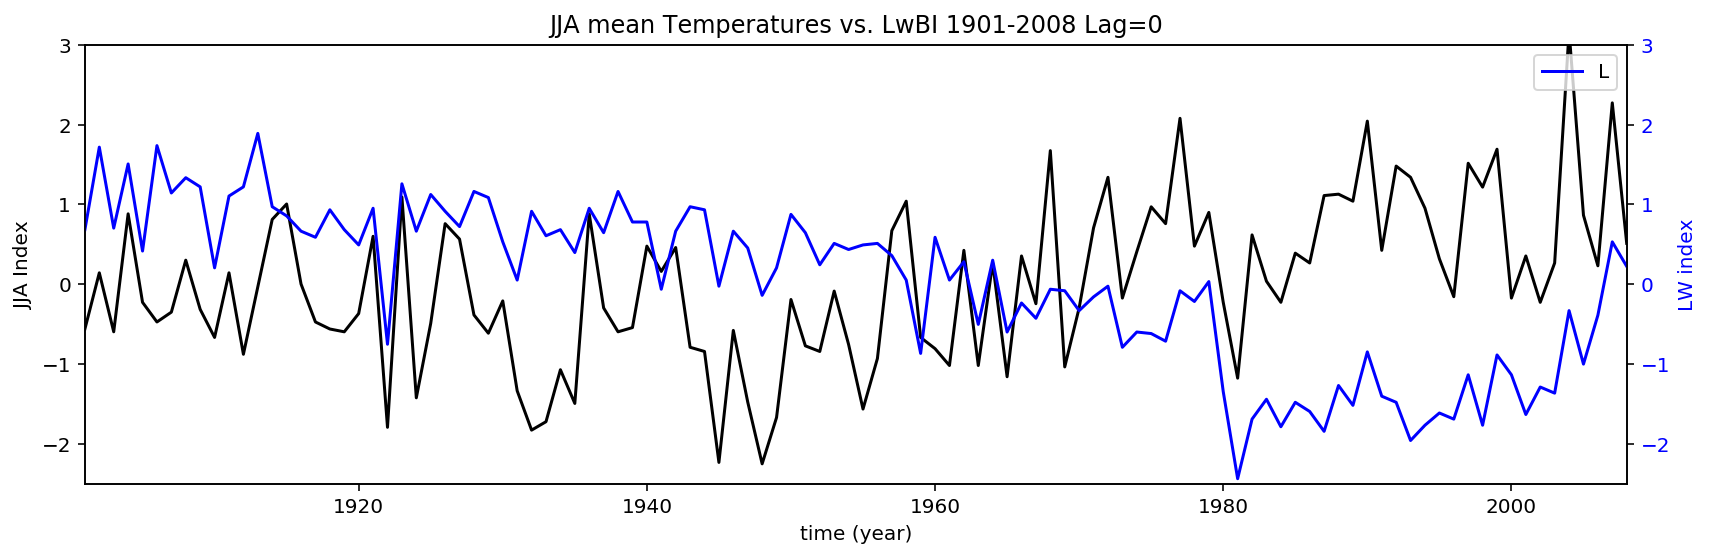

In [234]:
law=pd.read_csv('lw1901raw.csv',parse_dates = {'date_col' : ["year"]}) # raw data, 
law['date_col'] = pd.to_datetime(law['date_col'])
lwr=law['raw'].values
lw_z=((lwr-lwr.mean()))/lwr.std()

fig, ax1 = plt.subplots(figsize=(12, 4))
color = 'k'
year=tavg_DF[['JJA']].index
ax1.set_xlabel('time (year)')
ax1.set_ylabel('JJA Index')
ax1.plot(year, tavg_DF[['JJA']], color="k")
ax1.tick_params(axis='y',labelcolor=color)
ax1.set_ylim(-2.5,3)
ax1.set_xlim()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'b'
ax2.set_ylabel('LW index',color=color)  # we already handled the x-label with ax1
ax2.plot(year, lw_z,color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-2.5,3)

ax2.set_title('JJA mean Temperatures vs. LwBI 1901-2008 Lag=0')
ax2.legend('LW')
ax2.set_xlim(1901, 2008)
fig.tight_layout()# otherwise the right y-label is slightly clipped
plt.show()





# Conclusions 
- Need to be careful with standardization, Neg Exp is not the answer if we want to preserve those great long term trends we saw in the Motivation
- LWBI and RW, although measured on the same rings, are recording different climate informatino
- This site is xeric, so a drying trend limiting growth is not out of of the question, but i do not want to manipulate the data 

### Learning outcomes 
- Overall learned alot via documentation and translating my ideas into code
- lagged correlation vs. Dataframes
- for loops
- time indexing
- panda to xarray communication

### Major Challenges
- Attempting to concatenate spatial correlations into a data frame, or 
- correlate in general for 3D arrays

## TO DO
- Play with standardization methods
- for loop maps
- SPEI (i did this for SF originally, before i changed the standardization.........)
- PC analysis on individual Trees
- Clean up graphs & organize
